In [34]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from datetime import timedelta, datetime

In [26]:
### USER SETTINGS ###
database="/Volumes/mollyT7/MOXA"
# database = "/Volumes/MOLLY256/MOXA/"
# database = "/Users/molly/Desktop"

dates = [
    # "/Users/molly/Desktop/2024-01-26",
    # "2024-02-03",
    "2024-03-13",
    "2024-03-21",
]
devices = sorted([
    "sm00",
    "sm01",
])
exps = {
    # "QUIC-280sec": (6, ["#{:02d}".format(i + 1) for i in range(6)]),
    # "QUIC-300sec": (6, ["#{:02d}".format(i + 1) for i in range(6)]),
    # "QUIC-450sec": (6, ["#{:02d}".format(i + 1) for i in range(6)]),
    "QUIC-1M": (2, ["#{:02d}".format(i + 1) for i in range(2)]),
    "QUIC-5M": (2, ["#{:02d}".format(i + 1) for i in range(2)]),
    "QUIC-10M": (2, ["#{:02d}".format(i + 1) for i in range(2)]),
    "QUIC-inf": (6, ["#{:02d}".format(i + 1) for i in range(6)]),
}

device_to_port = {"sm00": [5200, 5201], 
                  "sm01": [5202, 5203],
                  "sm02": [5204, 5205]}

figure_path = "/Users/molly/Desktop"

In [5]:
all_ordered_ho_datas = {}
all_ho_dict = {'Conn_Rel': [], 'Conn_Req': [], 'LTE_HO': [], 'MN_HO': [], 'MN_HO_to_eNB': [], 'SN_setup': [], 'SN_Rel': [], 'SN_HO': [], 
               'RLF_II': [], 'RLF_III': [], 'SCG_RLF': []}
event_dict = {'Conn_Rel': 1, 'Conn_Req': 2, 'LTE_HO': 3, 'MN_HO': 4, 'MN_HO_to_eNB': 5, 'SN_setup': 6, 'SN_Rel': 7, 'SN_HO': 8, 'stable': 0, 
              'RLF_II': 9, 'RLF_III': 10, 'SCG_RLF': 11, 'Add_Scell': 12}
colors_dict = {'Conn_Rel': '#ed5555', 'Conn_Req': '#78c4b1', 'LTE_HO': '#3ea357', 'MN_HO': '#e8803a', 
               'MN_HO_to_eNB': '#ad58c4', 'SN_setup': '#ddbfde', 'SN_Rel': '#a1543f', 'SN_HO': '#d4c68a', 'stable': '#878483',
               'RLF_II': '#59a2c2', 'RLF_III': '#6494c4', 'SCG_RLF': '#646fc4'}

In [19]:
def find_stats_files(database, date, exp, device):
    ul_files = []
    dl_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'statistics')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.startswith("ul_statistics"):
                    ul_files.append(os.path.join(root, file))
                if file.startswith("dl_statistics"):
                    dl_files.append(os.path.join(root, file))
    return ul_files, dl_files

In [20]:
def calculate_avg_stats(df):
    avg_total_packets = int(df['total_packets'].mean())
    avg_data_packets  = int(df['total_data_packets'].mean())
    avg_original_pkl  = int(df['original_pkl'].mean())
    avg_reordering_threshold = int(df['reordering_threshold'].mean())
    avg_time_threshold = int(df['time_threshold'].mean())
    avg_real_pkl = int(df['reordering_threshold'].mean()) + int(df['time_threshold'].mean())
    
    return {"total_packets": avg_total_packets,
            "total_data_packets": avg_data_packets,
            "original_pkl": avg_original_pkl,
            "reordering_threshold": avg_reordering_threshold,
            "time_threshold": avg_time_threshold,
            "real_pkl": avg_real_pkl,
            "exec_reordering": int(df['exec_reordering'].mean()),
            "exec_time": int(df['exec_time'].mean()),
            "exec_lat": int(df['exec_reordering'].mean()) + int(df['exec_time'].mean()),
            "reordering_pkl_rate(%)": 0 if avg_real_pkl == 0 else avg_reordering_threshold*100 / avg_real_pkl,
            "time_pkl_rate(%)": 0 if avg_real_pkl == 0 else avg_time_threshold*100 / avg_real_pkl,
            "real_pkl_rate(%)": 0 if avg_original_pkl == 0 else avg_real_pkl*100 / avg_original_pkl,
            "original_packet_loss_rate(%)": avg_original_pkl*100 / avg_total_packets,
            "adjusted_packet_loss_rate(%)": avg_real_pkl*100 / avg_total_packets
            }

In [22]:
all_avg_ul_stats = {}
all_avg_dl_stats = {}
# Iterate over dates, exps, and devices
for exp in exps:
    exp_ul_stats_files = []
    exp_dl_stats_files = []
    for date in dates:
        for device in devices:
            ul_stats_files, dl_stats_files = find_stats_files(database, date, exp, device)
            exp_ul_stats_files.extend(ul_stats_files)
            exp_dl_stats_files.extend(dl_stats_files)
    stats = []
    # Iterate over each file path
    for file_path in exp_ul_stats_files:
        # Read CSV file into a DataFrame and append it to the list
        df = pd.read_csv(file_path, encoding="utf-8")
        stats.append(df)
    # Concatenate all DataFrames into a single DataFrame
    exp_ul_stats = pd.concat(stats, ignore_index=True)

    stats = []
    for file_path in exp_dl_stats_files:
        df = pd.read_csv(file_path, encoding="utf-8")
        stats.append(df)
    exp_dl_stats = pd.concat(stats, ignore_index=True)

    all_avg_ul_stats[exp] = calculate_avg_stats(exp_ul_stats)
    all_avg_dl_stats[exp] = calculate_avg_stats(exp_dl_stats)

all_avg_ul_stats


{'QUIC-1M': {'total_packets': 56631,
  'total_data_packets': 56504,
  'original_pkl': 239,
  'reordering_threshold': 5,
  'time_threshold': 32,
  'real_pkl': 37,
  'exec_reordering': 17,
  'exec_time': 183,
  'exec_lat': 200,
  'reordering_pkl_rate(%)': 13.513513513513514,
  'time_pkl_rate(%)': 86.48648648648648,
  'real_pkl_rate(%)': 15.481171548117155,
  'original_packet_loss_rate(%)': 0.42203033674136076,
  'adjusted_packet_loss_rate(%)': 0.06533524041602656},
 'QUIC-5M': {'total_packets': 282348,
  'total_data_packets': 282012,
  'original_pkl': 680,
  'reordering_threshold': 68,
  'time_threshold': 96,
  'real_pkl': 164,
  'exec_reordering': 244,
  'exec_time': 270,
  'exec_lat': 514,
  'reordering_pkl_rate(%)': 41.46341463414634,
  'time_pkl_rate(%)': 58.53658536585366,
  'real_pkl_rate(%)': 24.11764705882353,
  'original_packet_loss_rate(%)': 0.24083754799042317,
  'adjusted_packet_loss_rate(%)': 0.058084349809454996},
 'QUIC-10M': {'total_packets': 558623,
  'total_data_packets

In [31]:
all_avg_dl_stats

{'QUIC-1M': {'total_packets': 56535,
  'total_data_packets': 56425,
  'original_pkl': 182,
  'reordering_threshold': 10,
  'time_threshold': 164,
  'real_pkl': 174,
  'exec_reordering': 2,
  'exec_time': 5,
  'exec_lat': 7,
  'reordering_pkl_rate(%)': 5.747126436781609,
  'time_pkl_rate(%)': 94.25287356321839,
  'real_pkl_rate(%)': 95.6043956043956,
  'original_packet_loss_rate(%)': 0.3219244715662864,
  'adjusted_packet_loss_rate(%)': 0.3077739453435925},
 'QUIC-5M': {'total_packets': 281902,
  'total_data_packets': 281793,
  'original_pkl': 453,
  'reordering_threshold': 36,
  'time_threshold': 379,
  'real_pkl': 415,
  'exec_reordering': 15,
  'exec_time': 21,
  'exec_lat': 36,
  'reordering_pkl_rate(%)': 8.674698795180722,
  'time_pkl_rate(%)': 91.32530120481928,
  'real_pkl_rate(%)': 91.61147902869757,
  'original_packet_loss_rate(%)': 0.16069414193585005,
  'adjusted_packet_loss_rate(%)': 0.14721428013990678},
 'QUIC-10M': {'total_packets': 558150,
  'total_data_packets': 557540,

In [37]:
def plot_packet_loss_rate(all_avg_stats, ul_dl):
    experiments = list(all_avg_stats.keys())
    original_packet_loss_rates = [all_avg_stats[exp]['original_packet_loss_rate(%)'] for exp in experiments]
    adjusted_packet_loss_rates = [all_avg_stats[exp]['adjusted_packet_loss_rate(%)'] for exp in experiments]

    # Set the width of the bars
    bar_width = 0.35

    # Set the positions of the bars on the x-axis
    r1 = range(len(experiments))
    r2 = [x + bar_width for x in r1]

    # Create the bars for original packet loss rate
    plt.bar(r1, original_packet_loss_rates, color='b', width=bar_width, edgecolor='grey', label='Original Packet Loss Rate')
    # Create the bars for adjusted packet loss rate
    plt.bar(r2, adjusted_packet_loss_rates, color='r', width=bar_width, edgecolor='grey', label='Adjusted Packet Loss Rate')

    # Add xticks on the middle of the group bars
    plt.xlabel('Experiment', fontweight='bold')
    plt.xticks([r + bar_width/2 for r in range(len(experiments))], experiments, rotation=45)

    # Add labels and title
    plt.ylabel('Packet Loss Rate (%)', fontweight='bold')
    plt.title(f'Packet Loss Rates for Different Bitrates({ul_dl})', fontweight='bold')

    # Add legend
    plt.legend()
    plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5, zorder=0)

    # Show plot
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"{figure_path}/{ul_dl}_avg_pkl_rate.png")
    plt.show()


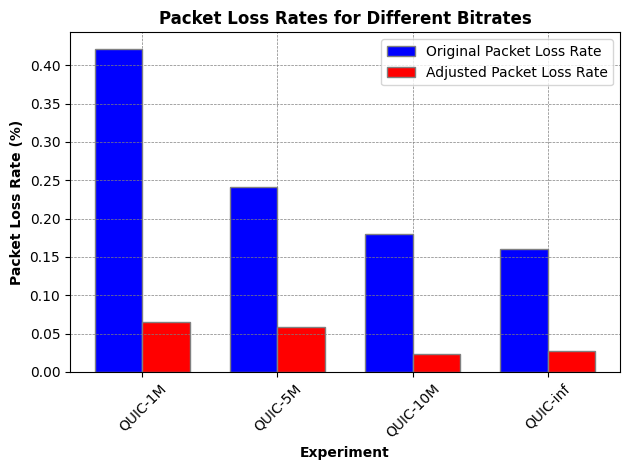

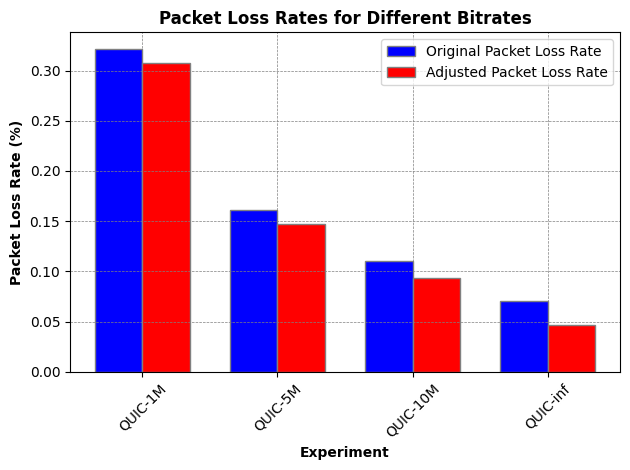

In [38]:
plot_packet_loss_rate(all_avg_ul_stats, "ul")
plot_packet_loss_rate(all_avg_dl_stats, "dl")

In [39]:
def plot_threshold_ratio(all_avg_stats, ul_dl):
    experiments = list(all_avg_stats.keys())
    reordering_pkl_rates = [all_avg_stats[exp]['reordering_pkl_rate(%)'] for exp in experiments]
    time_pkl_rates = [all_avg_stats[exp]['time_pkl_rate(%)'] for exp in experiments]

    # Set the width of the bars
    bar_width = 0.35

    # Set the positions of the bars on the x-axis
    r1 = range(len(experiments))
    r2 = [x + bar_width for x in r1]

    # Create the bars for original packet loss rate
    plt.bar(r1, reordering_pkl_rates, color='b', width=bar_width, edgecolor='grey', label='Reordering PKL Rate')

    # Create the bars for adjusted packet loss rate
    plt.bar(r2, time_pkl_rates, color='r', width=bar_width, edgecolor='grey', label='Time PKL Rate')

    # Add xticks on the middle of the group bars
    plt.xlabel('Experiment', fontweight='bold')
    plt.xticks([r + bar_width/2 for r in range(len(experiments))], experiments, rotation=45)

    # Add labels and title
    plt.ylabel('Packet Loss Rate (%)', fontweight='bold')
    plt.title(f'Triggered Threshold Rates for Different Bitrates({ul_dl})', fontweight='bold')

    # Add legend
    plt.legend()
    plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5, zorder=0)

    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{figure_path}/{ul_dl}_avg_threshold_pkl.png")
    plt.show()


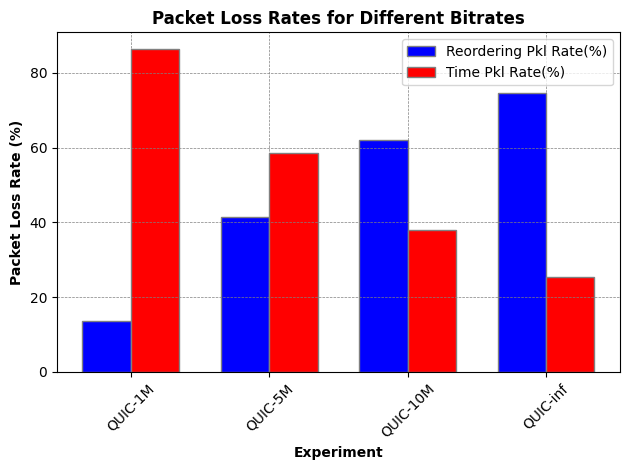

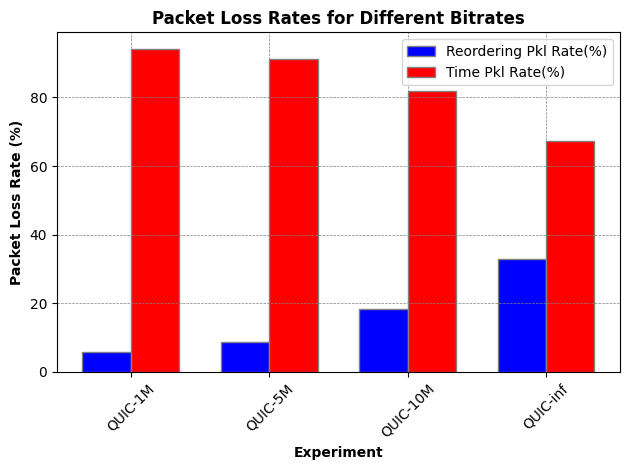

In [40]:
plot_threshold_ratio(all_avg_ul_stats, "ul")
plot_threshold_ratio(all_avg_dl_stats, "dl")

In [ ]:
def plot_threshold_real_pkl_ratio(all_avg_stats, ul_dl):
    experiments = list(all_avg_stats.keys())
    reordering_pkl_rates = [all_avg_stats[exp]['reordering_pkl_rate(%)'] for exp in experiments]
    time_pkl_rates = [all_avg_stats[exp]['time_pkl_rate(%)'] for exp in experiments]

    # Set the width of the bars
    bar_width = 0.35

    # Set the positions of the bars on the x-axis
    r1 = range(len(experiments))
    r2 = [x + bar_width for x in r1]

    # Create the bars for original packet loss rate
    plt.bar(r1, reordering_pkl_rates, color='b', width=bar_width, edgecolor='grey', label='Reordering PKL Rate')

    # Create the bars for adjusted packet loss rate
    plt.bar(r2, time_pkl_rates, color='r', width=bar_width, edgecolor='grey', label='Time PKL Rate')

    # Add xticks on the middle of the group bars
    plt.xlabel('Experiment', fontweight='bold')
    plt.xticks([r + bar_width/2 for r in range(len(experiments))], experiments, rotation=45)

    # Add labels and title
    plt.ylabel('Packet Loss Rate (%)', fontweight='bold')
    plt.title(f'Triggered Threshold Rates for Different Bitrates({ul_dl})', fontweight='bold')

    # Add legend
    plt.legend()
    plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5, zorder=0)

    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{figure_path}/{ul_dl}_avg_real_pkl.png")
    plt.show()


In [24]:
def find_ul_sent_file(database, date, exp, device):
    ul_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.startswith("processed_sent"):
                    
                    # Extract the numbers from the file name
                    numbers = file.split("_")[3]
                    print(ports[0])
                    if str(ports[0]) in numbers:
                        
                        ul_files.append(os.path.join(root, file))
                        break  # Exit the inner loop once the port is found
    return ul_files

def find_dl_sent_file(database, date, exp, device):
    dl_files = []
    exp_rounds, exp_list = exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "processed_sent" in file:
                    # Extract the numbers from the file name
                    numbers = file.split("_")[3]
                    if str(ports[1]) in numbers:
                        dl_files.append(os.path.join(root, file))
                        break  # Exit the inner loop once the port is found
    return dl_files

In [7]:
def calulate_goodput(sent_df):
    df_copy = sent_df.copy()
    df_copy.set_index(['packet_number', 'offset'], inplace=True)

    # Group by 'offset' and count occurrences
    offset_counts = df_copy.groupby(level='offset').size()

    # Identify repeated and not repeated offsets
    repeated_offsets = offset_counts[offset_counts > 1].index
    not_repeated_offsets = offset_counts[offset_counts == 1].index

    goodput = len(not_repeated_offsets)*100 / len(df_copy)
    return goodput

In [8]:
def plot_avg_goodput(avg_ul_goodput, avg_dl_goodput):
    # Extract experiment names and average goodput values
    exp_names_ul = list(avg_ul_goodput.keys())
    avg_ul_values = list(avg_ul_goodput.values())

    exp_names_dl = list(avg_dl_goodput.keys())
    avg_dl_values = list(avg_dl_goodput.values())

    # Plotting
    plt.figure(figsize=(10, 5))

    # Plot Uplink Goodput
    plt.plot(exp_names_ul, avg_ul_values, marker='o', color='skyblue', label='Uplink Goodput')

    # Plot Downlink Goodput
    plt.plot(exp_names_dl, avg_dl_values, marker='o', color='lightgreen', label='Downlink Goodput')

    # Add labels and title
    plt.xlabel('Experiment')
    plt.ylabel('Goodput (%)')
    plt.title('Average Uplink and Downlink Goodput')
    
    # Add legend
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [9]:
# TODO: Get all the files by different experiment
# TODO: Calculate the average goodput
# TODO: Draw the graph under differnet bitrate

In [28]:
all_ul_goodput = {}
all_dl_goodput = {}
# Iterate over dates, exps, and devices
for exp in exps:
    exp_ul_goodput = []
    exp_dl_goodput = []
    for date in dates:
        for device in devices:
            ul_sent_files = find_ul_sent_file(database, date, exp, device)
            dl_sent_files = find_dl_sent_file(database, date, exp, device)
            print(ul_sent_files)
            for ul_sent_file in ul_sent_files:
                ul_sent_df = pd.read_csv(ul_sent_file, sep='@')
                exp_ul_goodput.append(calulate_goodput(ul_sent_df))
            for dl_sent_file in dl_sent_files:
                dl_sent_df = pd.read_csv(dl_sent_file, sep='@')
                exp_dl_goodput.append(calulate_goodput(dl_sent_df))

    all_ul_goodput[exp] = exp_ul_goodput
    all_dl_goodput[exp] = exp_dl_goodput

avg_ul_goodput = {}
avg_dl_goodput = {}
# Calculate average uplink and downlink goodput for each experiment
for exp, ul_goodput_list in all_ul_goodput.items():
    avg_ul_goodput[exp] = sum(ul_goodput_list) / len(ul_goodput_list)
for exp, dl_goodput_list in all_dl_goodput.items():
    avg_dl_goodput[exp] = sum(dl_goodput_list) / len(dl_goodput_list)

print("Average Uplink Goodput:")
print(avg_ul_goodput)
print("\nAverage Downlink Goodput:")
print(avg_dl_goodput)


5200
5200
['/Volumes/mollyT7/MOXA/2024-03-13/QUIC-1M/sm00/#01/data/processed_sent_1053_5200.csv', '/Volumes/mollyT7/MOXA/2024-03-13/QUIC-1M/sm00/#02/data/processed_sent_1105_5200.csv']
5202
5202
['/Volumes/mollyT7/MOXA/2024-03-13/QUIC-1M/sm01/#01/data/processed_sent_1053_5202.csv', '/Volumes/mollyT7/MOXA/2024-03-13/QUIC-1M/sm01/#02/data/processed_sent_1105_5202.csv']
[]
[]
5200
5200
['/Volumes/mollyT7/MOXA/2024-03-13/QUIC-5M/sm00/#01/data/processed_sent_1118_5200.csv', '/Volumes/mollyT7/MOXA/2024-03-13/QUIC-5M/sm00/#02/data/processed_sent_1130_5200.csv']
5202
5202
['/Volumes/mollyT7/MOXA/2024-03-13/QUIC-5M/sm01/#01/data/processed_sent_1118_5202.csv', '/Volumes/mollyT7/MOXA/2024-03-13/QUIC-5M/sm01/#02/data/processed_sent_1130_5202.csv']
[]
[]
5200
5200
['/Volumes/mollyT7/MOXA/2024-03-13/QUIC-10M/sm00/#01/data/processed_sent_1143_5200.csv', '/Volumes/mollyT7/MOXA/2024-03-13/QUIC-10M/sm00/#02/data/processed_sent_1155_5200.csv']
5202
5202
['/Volumes/mollyT7/MOXA/2024-03-13/QUIC-10M/sm01/#0

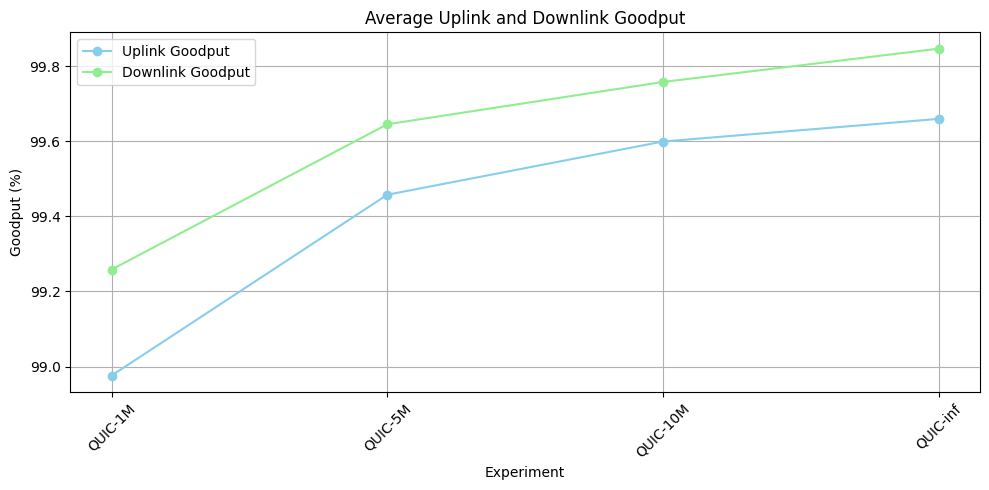

In [29]:
plot_avg_goodput(avg_ul_goodput, avg_dl_goodput)

Handover Section

In [99]:
def find_lost_pk_file(database, date, exp, device):
    ul_files = []
    dl_files = []
    rrc_files = []
    exp_round, exp_list = exps[exp]
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'data')
        for root, dirs, files in os.walk(folder_path):
            ul_file = ""
            dl_file = ""
            rrc_file = ""
            for file in files:
                if file.startswith("ul_real_lost_pk"):
                    ul_file = os.path.join(root, file)
                if file.startswith("dl_real_lost_pk"):
                    dl_file = os.path.join(root, file)
                if file.endswith("_rrc.csv"):
                    rrc_file = os.path.join(root, file)
                    
            if ul_file != "" and dl_file != "" and rrc_file != "":
                ul_files.append(ul_file)
                dl_files.append(dl_file)
                rrc_files.append(rrc_file)

    return ul_files, dl_files, rrc_files

def get_lost_data_from_df(df):
    lost_data_df = df[df['lost']==True]
    return lost_data_df

In [142]:
def count_records_within_1_second(loss_latency_df, D, event_dict):
    # Convert timestamp columns to datetime objects
    loss_latency_df['timestamp'] = pd.to_datetime(loss_latency_df['timestamp'])

    # Initialize a dictionary to store the counts for each event type
    event_counts = {}
    # event = {'Event Type': [], 'HO Object': [], 'before': [], 'before_event': [], 'during':[], 'during_event': [], 'after': [], 'after_event': []}
    events_list = []


    # Loop through each event type in D
    for event_type, ho_objects in D.items():
        if event_type == "Add_SCell":
            continue
        event_counts[event_type] = {'before': [], 'during':[], 'after': []}

        # Loop through each HO object in the current event type
        for ho in ho_objects:
            event = {'before': [], 'before_event': [], 'during':[], 'during_event': [], 'after': [], 'after_event': []}
            if ho.end is not None:
                start = ho.start
                end = ho.end
                sec_before_start = ho.start - timedelta(seconds=1)
                sec_after_end = ho.end + timedelta(seconds=1)
            else:
                # continue
                start = ho.start
                end = ho.start
                sec_before_start = ho.start - timedelta(seconds=1)
                sec_after_end = ho.start + timedelta(seconds=1)
            # print(start_time, ho.start, loss_latency_df['timestamp'])

            # Filter and display the records in loss_latency_df within the specified time range
            relevant_records_before = loss_latency_df[(start > loss_latency_df['timestamp']) & (loss_latency_df['timestamp'] >= sec_before_start)]
            relevant_records_after = loss_latency_df[(end < loss_latency_df['timestamp']) & (loss_latency_df['timestamp'] <= sec_after_end)]
            relevant_records_during = loss_latency_df[(start <= loss_latency_df['timestamp']) & (loss_latency_df['timestamp'] <= end)]

            for records_df in [relevant_records_before, relevant_records_during, relevant_records_after]:
                records_df.loc[records_df['ho_type'] == 0, 'ho_type'] = event_dict[event_type]

            loss_latency_df.loc[relevant_records_before.index] = relevant_records_before
            loss_latency_df.loc[relevant_records_during.index] = relevant_records_during
            loss_latency_df.loc[relevant_records_after.index] = relevant_records_after
            
            # print(relevant_records_before['ho_type'])

            event_counts[event_type]['before'].append(len(relevant_records_before))
            # event_counts[event_type]['before_event'].append(relevant_records_before)
            event_counts[event_type]['after'].append(len(relevant_records_after))
            # event_counts[event_type]['after_event'].append(relevant_records_after)
            event_counts[event_type]['during'].append(len(relevant_records_during))
            # event_counts[event_type]['during_event'].append(relevant_records_during)

            event['Event Type'] = f"{event_type}"
            event['HO Object'] = f"{ho}"
            event['before'] = len(relevant_records_before)
            event['before_event'] = relevant_records_before
            event['during'] = len(relevant_records_during)
            event['during_event'] = relevant_records_during
            event['after'] = len(relevant_records_after)
            event['after_event'] = relevant_records_after

            events_list.append(event)

    return events_list, event_counts, loss_latency_df

def calculate_event_sums_lists(event_counts):
    success_sum_before = {}
    success_sum_during = {}
    success_sum_after = {}
    failure_sum_before = {}
    failure_sum_during= {}
    failure_sum_after = {}
    # Initialize lists to store the sums of before, during, and after counts
    success_sum_before_list = []
    success_sum_during_list = []
    success_sum_after_list = []
    failure_sum_before_list = []
    failure_sum_during_list = []
    failure_sum_after_list = []

    # Loop through each event type
    for event_type, counts in event_counts.items():
        # Initialize sums for this event type
        if (event_type == 'RLF_II') or (event_type == 'RLF_III') or (event_type == 'SCG_RLF'):
            failure_sum_before[event_type] = sum(counts['before'])
            failure_sum_during[event_type] = sum(counts['during'])
            failure_sum_after[event_type] = sum(counts['after'])
            failure_sum_before_list.append(sum(counts['before']))
            failure_sum_during_list.append(sum(counts['during']))
            failure_sum_after_list.append(sum(counts['after']))
            
        elif (event_type != 'Add_SCell'):
            success_sum_before[event_type] = sum(counts['before'])
            success_sum_during[event_type] = sum(counts['during'])
            success_sum_after[event_type] = sum(counts['after'])
            success_sum_before_list.append(sum(counts['before']))
            success_sum_during_list.append(sum(counts['during']))
            success_sum_after_list.append(sum(counts['after']))

    return success_sum_before_list, success_sum_during_list, success_sum_after_list, failure_sum_before_list, failure_sum_during_list, failure_sum_after_list, success_sum_before, success_sum_during, success_sum_after, failure_sum_before, failure_sum_during, failure_sum_after

def plot_event_sums(exp_name, success_sum_before_list, success_sum_during_list, success_sum_after_list, failure_sum_before_list, failure_sum_during_list, failure_sum_after_list, ul_dl):
    x = ['Conn_Rel',
         'Conn_Req',  # Setup
         'LTE_HO',  # LTE -> newLTE
         'MN_HO',  # LTE + NR -> newLTE + NR
         'MN_HO_to_eNB',  # LTE + NR -> newLTE
         'SN_setup',  # LTE -> LTE + NR => NR setup
         'SN_Rel',  # LTE + NR -> LTE
         'SN_HO',  # LTE + NR -> LTE + newNR
         ]

    w = 0.2

    # Create an array of indices for x-axis positioning
    indices = np.arange(len(x))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))  # 2 rows, 1 column of subplots
    ax1.bar(indices, success_sum_before_list, color='#edc56d', width=0.15, align='edge', label='before event')
    ax1.bar(indices + 1.1 * w, success_sum_during_list, color='#6db6ed', width=0.15, label='during event')
    ax1.bar(indices + 1.8 * w, success_sum_after_list, color='#e4a2f2', width=0.15, label='after event')
    if ul_dl == "ul":
        ax1.set_title(f"Handover Interval Loss: {exp_name} Uplink")
    elif ul_dl == "dl":
        ax1.set_title(f"Handover Interval Loss: {exp_name} Downlink")
    # Set custom x-axis labels
    ax1.set_xticks(indices + w)
    ax1.set_xticklabels(x)
    ax1.legend()

    x2 = ['RLF_II',  # fail but reestablishment success
          'RLF_III',  # fail but reestablishment reject
          'SCG_RLF'
          ]

    # Create an array of indices for x-axis positioning
    indices2 = np.arange(len(x2))

    ax2.bar(indices2, failure_sum_before_list, color='#edc56d', width=0.15, align='edge', label='before event')
    ax2.bar(indices2 + 1.1 * w, failure_sum_during_list, color='#6db6ed', width=0.15, label='during event')
    ax2.bar(indices2 + 1.8 * w, failure_sum_after_list, color='#e4a2f2', width=0.15, label='after event')
    ax2.set_xticks(indices2 + 1 * w)
    ax2.set_xticklabels(x2)
    ax2.legend()

    # Adjust spacing between subplots
    plt.tight_layout()
    # plt.savefig(f"{figure_path}/{exp_name}_ho_events_{ul_dl}.png")
    plt.show()


In [132]:
all_data_files = {}
# Iterate over dates, exps, and devices
for exp in exps:
    exp_data_files = {"ul_lost_file": [], "dl_lost_file": [], "rrc_file": []}
    exp_ul_lost_pk_files = []
    exp_dl_lost_pk_files = []
    exp_rrc_files = []
    for date in dates:
        for device in devices:
            # Find "rrc" files for the current combination of date, exp, and device
            exp_ul_lost_pk_files, exp_dl_lost_pk_files, exp_rrc_files = find_lost_pk_file(database, date, exp, device)
            exp_data_files["ul_lost_file"].extend(exp_ul_lost_pk_files)
            exp_data_files["dl_lost_file"].extend(exp_dl_lost_pk_files)
            exp_data_files["rrc_file"].extend(exp_rrc_files)

    all_data_files[exp] = exp_data_files


2024-03-13 02:53:50.085172 | MN_HO | (44, 3050) -> (329, 3050) | 44 | eventA3 | {}
2024-03-13 02:53:55.524014 | SN_HO | (329, 3050) | 44 -> 329 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-03-13 02:54:11.151938 | SN_HO | (329, 3050) | 329 -> 87 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-03-13 02:54:11.228349 | MN_HO_to_eNB | (329, 3050) -> (87, 3050) | 87 -> O | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 02:54:11.542629 | SN_setup | (87, 3050) | O -> 87 | eventB1-NR-r15 | {'thr': '[-111&-110)', 'hys': 0, 'ttt': 100}
2024-03-13 02:54:27.172634 | MN_HO | (87, 3050) -> (287, 3050) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 02:54:44.656731 | MN_HO | (287, 3050) -> (279, 3050) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 02:54:46.362950 | MN_HO | (279, 3050) -> (287, 3050) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 02:54:49.815794 | MN_HO | (287, 3050) -> (329, 3050) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}


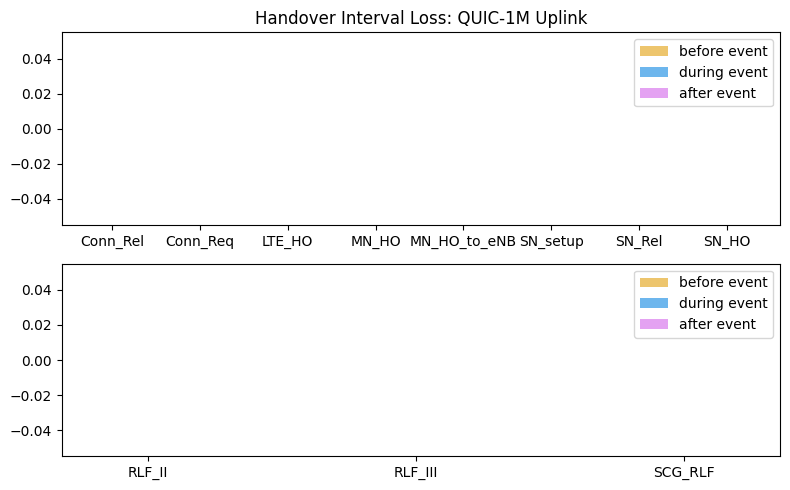

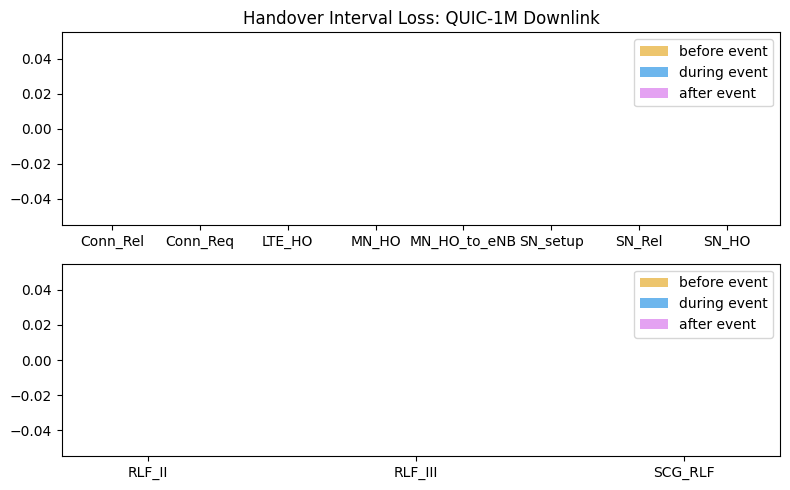

2024-03-13 03:18:47.976990 | SN_HO | (44, 1750) | O -> 329 | eventA3 | {}
2024-03-13 03:18:49.795600 | MN_HO | (44, 1750) -> (134, 1750) | 329 | eventA3 | {}
2024-03-13 03:18:51.616484 | RLF_II | (134, 1750) -> (329, 1750) | 329 -> O
2024-03-13 03:18:51.955395 | SN_setup | (329, 1750) | O -> 329 | eventB1-NR-r15 | {'thr': '[-111&-110)', 'hys': 0, 'ttt': 100}
2024-03-13 03:18:58.580264 | MN_HO | (329, 1750) -> (44, 1750) | 329 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 03:19:04.876451 | RLF_II | (44, 1750) -> (87, 1750) | 329 -> O
2024-03-13 03:19:05.211541 | SN_setup | (87, 1750) | O -> 87 | eventB1-NR-r15 | {'thr': '[-111&-110)', 'hys': 0, 'ttt': 100}
2024-03-13 03:20:11.885094 | MN_HO | (87, 1750) -> (271, 1750) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 03:20:18.579590 | SN_HO | (271, 1750) | 87 -> 271 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-03-13 03:20:38.075767 | RLF_II | (271, 1750) -> (84, 1750) | 271 -> O
2024-03-13 03:20:38.913970 | SN_

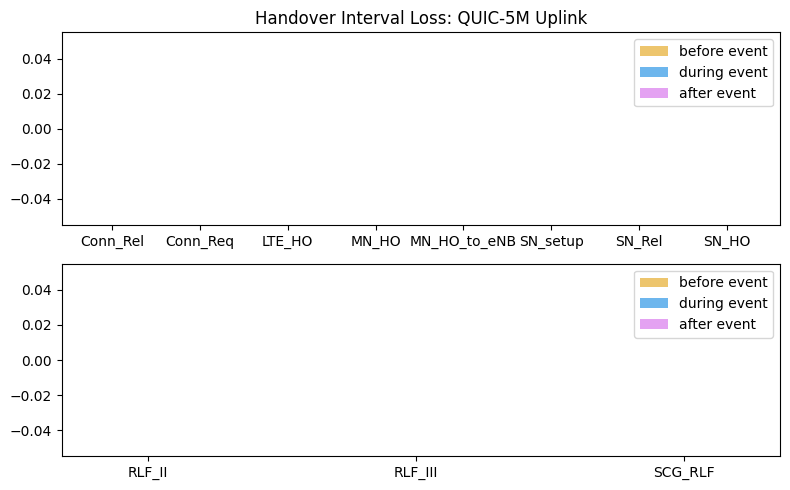

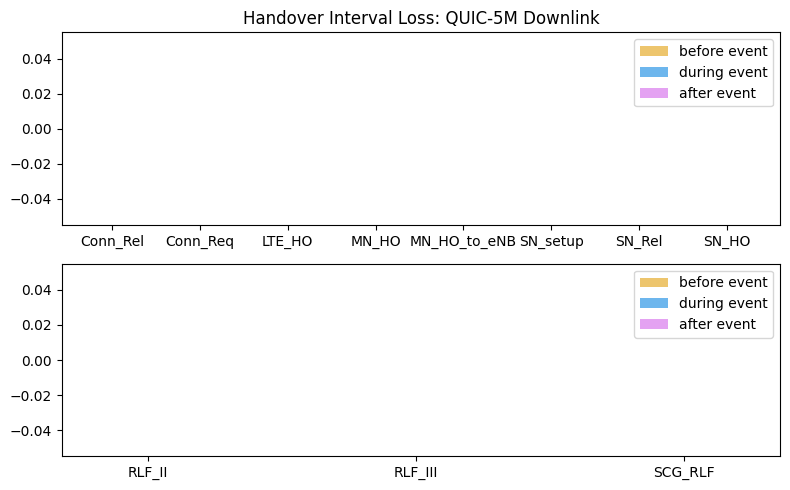

2024-03-13 03:43:51.524328 | SN_HO | (44, 1750) | O -> 329 | eventA3 | {}
2024-03-13 03:43:54.896672 | MN_HO | (44, 1750) -> (329, 1750) | 329 | eventA3 | {}
2024-03-13 03:44:08.573165 | MN_HO | (329, 1750) -> (87, 1750) | 329 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 03:44:09.884316 | SN_HO | (87, 1750) | 329 -> 87 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-03-13 03:44:28.793295 | MN_HO | (87, 1750) -> (287, 1750) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 03:44:40.165233 | MN_HO | (287, 1750) -> (271, 1750) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 03:45:22.485064 | SN_HO | (271, 1750) | 87 -> 271 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-03-13 03:45:34.635690 | MN_HO | (271, 1750) -> (69, 1750) | 271 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 03:45:36.312095 | MN_HO | (69, 1750) -> (84, 1750) | 271 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-13 03:45:42.046769 | SN_HO | (84, 1750) | 271 -> 84 | e

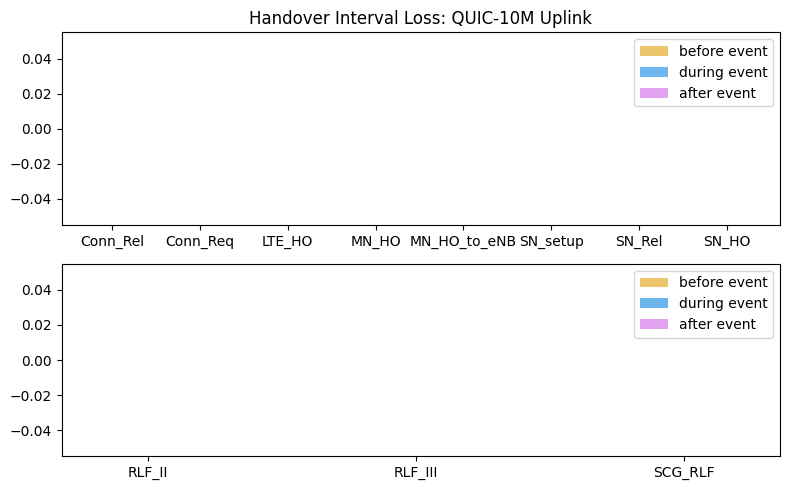

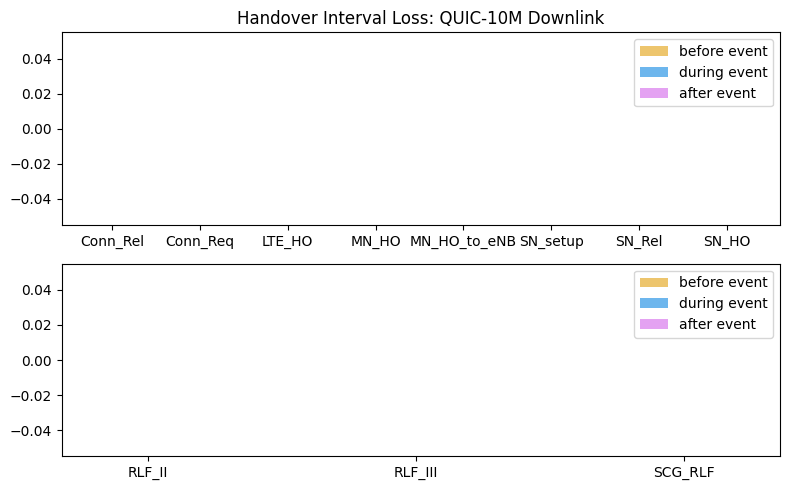

2024-03-21 15:24:19.264211 | SN_HO | (329, 3050) | O -> 87 | eventA3 | {}
2024-03-21 15:24:19.656049 | MN_HO | (329, 3050) -> (87, 3050) | 87 | eventA3 | {}
2024-03-21 15:24:36.491545 | MN_HO | (87, 3050) -> (287, 3050) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-21 15:25:32.004597 | MN_HO | (287, 3050) -> (26, 3050) | 87 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-21 15:25:33.978247 | RLF_II | (26, 3050) -> (271, 1750) | 87 -> O
2024-03-21 15:25:34.429558 | SN_setup | (271, 1750) | O -> 271 | eventB1-NR-r15 | {'thr': '[-111&-110)', 'hys': 0, 'ttt': 100}
2024-03-21 15:25:50.520629 | MN_HO | (271, 1750) -> (353, 1750) | 271 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-21 15:25:51.369625 | MN_HO | (353, 1750) -> (84, 1750) | 271 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-03-21 15:25:53.263429 | SN_HO | (84, 1750) | 271 -> 84 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-03-21 15:25:56.615736 | SN_HO | (84, 1750) | 84 -> 353 | eventA3 | {'off': 6,

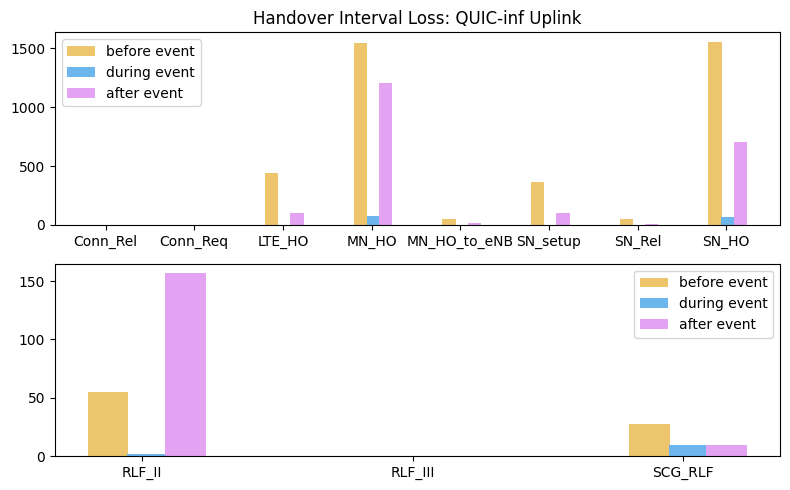

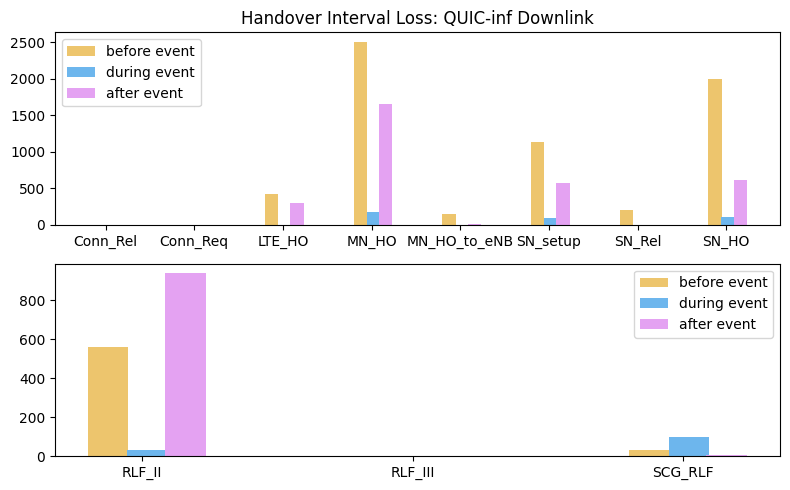

In [143]:
all_event_lost_sum_ul = {}
all_event_lost_sum_dl = {}
rrc_time_pattern = r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})"
for exp in exps:
    exp_event_lost_sum_ul = {"success_before": [0] * 8,"success_during": [0] * 8, "success_after": [0] * 8, "failure_before": [0] * 3, "failure_during": [0] * 3, "failure_after": [0] * 3}
    exp_event_lost_sum_dl = {"success_before": [0] * 8,"success_during": [0] * 8, "success_after": [0] * 8, "failure_before": [0] * 3, "failure_during": [0] * 3, "failure_after": [0] * 3}
    for idx, (ul_file, dl_file, rrc_file) in enumerate(zip(all_data_files[exp]["ul_lost_file"], all_data_files[exp]["dl_lost_file"], all_data_files[exp]["rrc_file"])):
        # rrc_file
        HOs = parse_mi_ho(rrc_file)
        MRs = MeasureReport(rrc_file)
        MRs = correct_MR_with_HO(MRs, HOs)
        mappings = map_MR_HO(MRs, HOs)
        ordered_HOs = print_trans(HOs, mappings=mappings)
        match = re.search(rrc_time_pattern, os.path.basename(rrc_file))
        if match:
            start_time = match.group(1)
            # Convert the timestamp string to a datetime object
            start_timestamp = datetime.strptime(start_time, '%Y-%m-%d_%H-%M-%S')
            # Filter entries based on the threshold timestamp
            filtered_entries = [entry for entry in ordered_HOs if entry[1].start > start_timestamp]
        start_timestamp = datetime.strptime(start_time, '%Y-%m-%d_%H-%M-%S')
        # Filter the data based on the start timestamp
        filtered_time_ordered_HO = [entry for entry in ordered_HOs if entry[1].start > start_timestamp]

        # ul_sent_file
        ul_lost_df = pd.read_csv(ul_file, encoding="utf-8")
        ul_lost_df['timestamp'] = pd.to_datetime(ul_lost_df['timestamp'])
        ul_lost_df['ho_type'] = 0
        event_list_ul, event_counts_ul, ul_lost_df = count_records_within_1_second(ul_lost_df, HOs, event_dict)
        success_sum_before_list_ul, success_sum_during_list_ul, success_sum_after_list_ul, failure_sum_before_list_ul, failure_sum_during_list_ul, failure_sum_after_list_ul, success_sum_before_ul, success_sum_during_ul, success_sum_after_ul, failure_sum_before_ul, failure_sum_during_ul, failure_sum_after_ul = calculate_event_sums_lists(event_counts_ul)
        # Print the results
        print("Success Sum Before List (ul):", success_sum_before_list_ul)
        print("Success Sum During List (ul):", success_sum_during_list_ul)
        print("Success Sum After List (ul):", success_sum_after_list_ul)
        print("Failure Sum Before List (ul):", failure_sum_before_list_ul)
        print("Failure Sum During List (ul):", failure_sum_during_list_ul)
        print("Failure Sum After List (ul):", failure_sum_after_list_ul)


        exp_event_lost_sum_ul = {"success_before": [a + b for a, b in zip(exp_event_lost_sum_ul["success_before"], success_sum_before_list_ul)], 
                                 "success_during": [a + b for a, b in zip(exp_event_lost_sum_ul["success_during"], success_sum_during_list_ul)], 
                                 "success_after": [a + b for a, b in zip(exp_event_lost_sum_ul["success_after"], success_sum_after_list_ul)], 
                                 "failure_before": [a + b for a, b in zip(exp_event_lost_sum_ul["failure_before"], failure_sum_before_list_ul)], 
                                 "failure_during": [a + b for a, b in zip(exp_event_lost_sum_ul["failure_during"], failure_sum_during_list_ul)], 
                                 "failure_after": [a + b for a, b in zip(exp_event_lost_sum_ul["failure_after"], failure_sum_after_list_ul)]
                                }

        # dl_sent_file
        dl_lost_df = pd.read_csv(dl_file, encoding="utf-8")
        dl_lost_df['timestamp'] = pd.to_datetime(dl_lost_df['timestamp'])
        dl_lost_df['ho_type'] = 0
        event_list_dl, event_counts_dl, dl_lost_df = count_records_within_1_second(dl_lost_df, HOs, event_dict)
        success_sum_before_list_dl, success_sum_during_list_dl, success_sum_after_list_dl, failure_sum_before_list_dl, failure_sum_during_list_dl, failure_sum_after_list_dl, success_sum_before_dl, success_sum_during_dl, success_sum_after_dl, failure_sum_before_dl, failure_sum_during_dl, failure_sum_after_dl = calculate_event_sums_lists(event_counts_dl)
        # Print the results
        print("Success Sum Before List (dl):", success_sum_before_list_dl)
        print("Success Sum During List (dl):", success_sum_during_list_dl)
        print("Success Sum After List (dl):", success_sum_after_list_dl)
        print("Failure Sum Before List (dl):", failure_sum_before_list_dl)
        print("Failure Sum After List (dl):", failure_sum_after_list_dl)

        exp_event_lost_sum_dl = {"success_before": [a + b for a, b in zip(exp_event_lost_sum_dl["success_before"], success_sum_before_list_dl)], 
                                 "success_during": [a + b for a, b in zip(exp_event_lost_sum_dl["success_during"], success_sum_during_list_dl)], 
                                 "success_after": [a + b for a, b in zip(exp_event_lost_sum_dl["success_after"], success_sum_after_list_dl)], 
                                 "failure_before": [a + b for a, b in zip(exp_event_lost_sum_dl["failure_before"], failure_sum_before_list_dl)], 
                                 "failure_during": [a + b for a, b in zip(exp_event_lost_sum_dl["failure_during"], failure_sum_during_list_dl)],
                                 "failure_after": [a + b for a, b in zip(exp_event_lost_sum_dl["failure_after"], failure_sum_after_list_dl)]
                                }
    
    all_event_lost_sum_ul[exp] = exp_event_lost_sum_ul
    all_event_lost_sum_dl[exp] = exp_event_lost_sum_dl

    plot_event_sums(exp, exp_event_lost_sum_ul["success_before"], exp_event_lost_sum_ul["success_during"], exp_event_lost_sum_ul["success_after"], exp_event_lost_sum_ul["failure_before"], exp_event_lost_sum_ul["failure_during"], exp_event_lost_sum_ul["failure_after"], "ul")
    plot_event_sums(exp, exp_event_lost_sum_dl["success_before"], exp_event_lost_sum_dl["success_during"], exp_event_lost_sum_dl["success_after"], exp_event_lost_sum_dl["failure_before"], exp_event_lost_sum_dl["failure_during"], exp_event_lost_sum_dl["failure_after"], "dl")

## UDP

In [10]:
### USER SETTINGS ###
database="/Volumes/mollyT7/MOXA"
# database = "/Volumes/MOLLY256/MOXA/"
# database = "/Users/molly/Desktop"

dates = [
    # "/Users/molly/Desktop/2024-01-26",
    # "2024-02-03",
    "2024-03-13",
    # "2024-03-21",
]
devices = sorted([
    "sm00",
    "sm01",
])
udp_exps = {
    "UDP-1M": (2, ["#{:02d}".format(i + 1) for i in range(2)]),
    "UDP-5M": (2, ["#{:02d}".format(i + 1) for i in range(2)]),
    "UDP-10M": (2, ["#{:02d}".format(i + 1) for i in range(2)]),
}

device_to_port = {"sm00": [3200, 3201], 
                  "sm01": [3202, 3203],
                  "sm02": [3204, 3205]}

figure_path = "/Users/molly/Desktop"

In [11]:
def find_loss_stats_files(database, date, exp, device):
    ul_files = []
    dl_files = []
    exp_rounds, exp_list = udp_exps[exp]
    ports = device_to_port.get(device, [])
    for exp_round in exp_list:
        folder_path = os.path.join(database, date, exp, device, exp_round, 'statistics')
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.startswith("udp_uplk_loss_statistics"):
                    ul_files.append(os.path.join(root, file))
                if file.startswith("udp_dnlk_loss_statistics"):
                    dl_files.append(os.path.join(root, file))
    return ul_files, dl_files

In [20]:
def calculate_avg_udp_stats(df):
    avg_total_packets = int(df['total_packet_sent'].mean())
    avg_packet_loss = int(df['total_packet_loss'].mean())
    
    return {"total_packet_sent": avg_total_packets,
            "total_packet_loss": avg_packet_loss,
            "packet_loss_rate(%)": avg_packet_loss*100 / avg_total_packets,
            "experiment_time(sec)": df['experiment_time(sec)'].mean()
            }

In [21]:

all_avg_udp_ul_stats = {}
all_avg_udp_dl_stats = {}
# Iterate over dates, exps, and devices
for exp in udp_exps:
    exp_udp_ul_stats_files = []
    exp_udp_dl_stats_files = []
    for date in dates:
        for device in devices:
            ul_stats_files, dl_stats_files = find_loss_stats_files(database, date, exp, device)
            exp_udp_ul_stats_files.extend(ul_stats_files)
            exp_udp_dl_stats_files.extend(dl_stats_files)
    stats = []
    # Iterate over each file path
    for file_path in exp_udp_ul_stats_files:
        # Read CSV file into a DataFrame and append it to the list
        df = pd.read_csv(file_path, encoding="utf-8")
        stats.append(df)
    # Concatenate all DataFrames into a single DataFrame
    exp_ul_stats = pd.concat(stats, ignore_index=True)

    stats = []
    for file_path in exp_udp_dl_stats_files:
        df = pd.read_csv(file_path, encoding="utf-8")
        stats.append(df)
    exp_dl_stats = pd.concat(stats, ignore_index=True)

    all_avg_udp_ul_stats[exp] = calculate_avg_udp_stats(exp_ul_stats)
    all_avg_udp_dl_stats[exp] = calculate_avg_udp_stats(exp_dl_stats)

all_avg_udp_ul_stats


{'UDP-1M': {'total_packet_sent': 44843,
  'total_packet_loss': 62,
  'packet_loss_rate(%)': 0.1382601520861673,
  'experiment_time(sec)': 358.7313815},
 'UDP-5M': {'total_packet_sent': 216226,
  'total_packet_loss': 749,
  'packet_loss_rate(%)': 0.34639682554364415,
  'experiment_time(sec)': 345.96626125},
 'UDP-10M': {'total_packet_sent': 423218,
  'total_packet_loss': 676,
  'packet_loss_rate(%)': 0.15972855596879149,
  'experiment_time(sec)': 338.52887975}}

In [22]:
all_avg_udp_dl_stats

{'UDP-1M': {'total_packet_sent': 44843,
  'total_packet_loss': 709,
  'packet_loss_rate(%)': 1.581071739178913,
  'experiment_time(sec)': 358.73138125},
 'UDP-5M': {'total_packet_sent': 216226,
  'total_packet_loss': 4552,
  'packet_loss_rate(%)': 2.105204739485538,
  'experiment_time(sec)': 345.9662565},
 'UDP-10M': {'total_packet_sent': 423218,
  'total_packet_loss': 8275,
  'packet_loss_rate(%)': 1.9552571015410498,
  'experiment_time(sec)': 338.5288795}}

In [45]:
def plot_udp_packet_loss_rate(all_avg_stats, ul_dl):
    experiments = list(all_avg_stats.keys())
    packet_loss_rate = [all_avg_stats[exp]['packet_loss_rate(%)'] for exp in experiments]

    # Set the width of the bars
    bar_width = 0.35

    # Set the positions of the bars on the x-axis
    r1 = range(len(experiments))
    r2 = [x + bar_width for x in r1]

    # Create the bars for original packet loss rate
    plt.bar(r1, packet_loss_rate, color='b', width=bar_width, edgecolor='grey', label='Packet Loss Rate')

    # Add xticks on the middle of the group bars
    plt.xlabel('Experiment', fontweight='bold')
    plt.xticks([r + bar_width/2 for r in range(len(experiments))], experiments, rotation=45)

    # Add labels and title
    plt.ylabel('Packet Loss Rate (%)', fontweight='bold')
    plt.title('Packet Loss Rates for Different Bitrates', fontweight='bold')

    # Add legend
    plt.legend()
    plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5, zorder=0)

    # Show plot
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"{figure_path}/{ul_dl}_avg_udp_pkl_rate.png")
    plt.show()


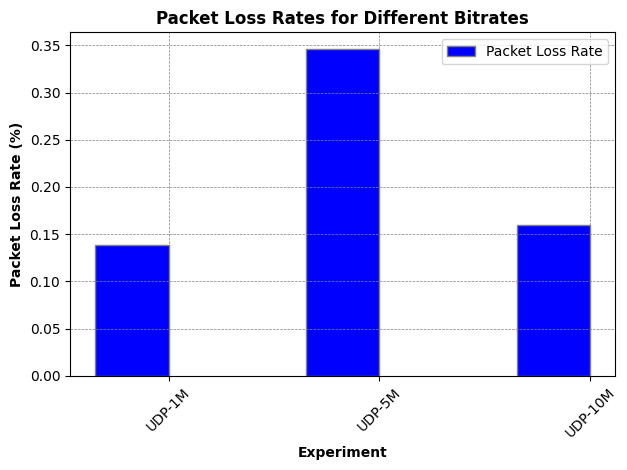

In [46]:
plot_udp_packet_loss_rate(all_avg_udp_ul_stats, "ul")

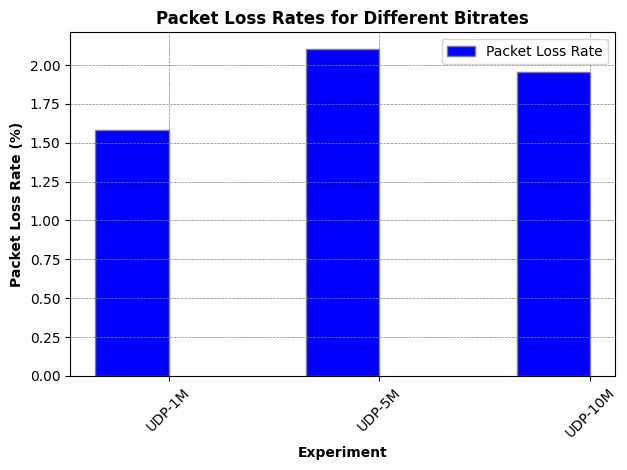

In [47]:
plot_udp_packet_loss_rate(all_avg_udp_dl_stats, "dl")

TESTING

In [118]:
import json
import csv

def QlogToJsonEntry(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Add commas between lines
    json_str = ",".join(lines)
    # Surround the entire string with square brackets to create a JSON array
    json_str = "[" + json_str + "]"
    # Load the JSON array
    json_entry = json.loads(json_str)
    
    return json_entry

def QlogToJson(json_entry, json_file_path):
    with open(json_file_path, 'w') as json_file:
        json.dump(json_entry, json_file, indent=2)

def JsonToCsv(json_entry, csv_file_path):
     # Open CSV file for writing
    with open(csv_file_path, 'w', newline='') as csv_file:
        # Create a CSV writer
        csv_writer = csv.writer(csv_file)

        # Write header row based on the keys of the second JSON object (assuming at least two objects are present)
        if len(json_entry) >= 2:
            header = list(json_entry[1].keys())
            csv_writer.writerow(header)

            # Write data rows starting from the second object
            for entry in json_entry[1:]:
                csv_writer.writerow(entry.values())

In [128]:
# sender_side_file
sent_raw_path = "/Volumes/mollyT7/MOXA/2024-04-24/QUIC-10M/sm01/#02/raw/log_20240424_1347_5203_server"
sent_qlog_file_path = sent_raw_path + ".qlog"
sent_json_file_path = sent_raw_path + ".json"
sent_csv_file_path = sent_raw_path + ".csv"
sent_json_entry = QlogToJsonEntry(sent_qlog_file_path)
# QlogToJson(sent_json_entry, sent_json_file_path)
JsonToCsv(sent_json_entry, sent_csv_file_path)

In [129]:
dl_sender_df = pd.read_csv(sent_csv_file_path)
dl_sent_df = dl_sender_df[(dl_sender_df['name'] == 'transport:packet_sent')]
dl_lost_df = dl_sender_df[(dl_sender_df['name'] == 'recovery:packet_lost')]
dl_received_df = dl_sender_df[(dl_sender_df['name'] == 'transport:packet_received')]
pk_sent_rows = dl_sent_df['data'].str.contains("'frame_type': 'stream'")

In [130]:
print(len(dl_sent_df), len(dl_lost_df), len(dl_received_df))
print(len(dl_sent_df) + len(dl_received_df))
print(len(pk_sent_rows))

559777 1207 86249
646026
559777
